##### install yasa

In [1]:
!pip install --upgrade yasa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.8 MB 141 kB/s 
     |████████████████████████████████| 7.5 MB 45.4 MB/s 
     |████████████████████████████████| 423 kB 22.8 MB/s 
     |████████████████████████████████| 365 kB 40.5 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 1.6 MB 66.5 MB/s 
  Created wheel for yasa: filename=yasa-0.6.2-py3-none-any.whl size=33797167 sha256=81b38f5c8fd59ac63b074f42c9d6ef43615585d57b5f7fea26e8a044c8d043fe
  Stored in directory: /root/.cache/pip/wheels/52/8c/9c/1352fced5b6240ed1e3669f477d7ce0e2fe693e28b7bcc45f4
  Created wheel for pyriemann: filename=pyriemann-0.3-py2.py3-none-any.whl size=78033 sha256=7b1475decba8b7f6a78bda91908cb5e278cff214dcb1bdc77a35901cdaa69cf7
  Stored in directory: /root/

# Spindles detection on specific sleep stages

This notebook demonstrates how to apply **spindles detection on specific sleep stages** by providing an hypnogram (= sleep stage) to YASA.

Please make sure to install the latest version of YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`


## 1. Loading the EEG data and the hypnogram

We first load a full-night 3-channels dataset (Cz, Fz, Pz) sampled at 100 Hz. The data is in compressed NumPy format (*.npz*).

In [2]:
#구글드라이브 공유폴더에서 불러오기
!gdown --id 1z7uUvoDxHQhCCnIu48RwWspQy9mRRouV --output 02_data_full_6hrs_100Hz_Cz+Fz+Pz.npz

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1z7uUvoDxHQhCCnIu48RwWspQy9mRRouV
To: /content/02_data_full_6hrs_100Hz_Cz+Fz+Pz.npz
100% 14.7M/14.7M [00:00<00:00, 101MB/s] 


In [3]:
import yasa
import numpy as np
import pandas as pd
import seaborn as sns

# Load data
f = np.load('/content/02_data_full_6hrs_100Hz_Cz+Fz+Pz.npz')
data, ch_names = f['data'], f['chan']
sf = 100.
times = np.arange(data.size) / sf

print(data.shape, ch_names)
print(np.round(data[:, 0:5], 3))

(3, 2161058) ['Cz' 'Fz' 'Pz']
[[15.797 22.307 39.922 25.657 27.094]
 [16.896 26.385 40.966 21.833 24.456]
 [ 5.899 14.297 36.592 26.094 23.395]]


Next, we load the sleep staging vector (a.k.a hypnogram), which is a simple text file in which each value typically represents 30 seconds of data. Sleep stages are encoded as integer (*0: Wake, 1: N1 sleep, 2: N2 sleep, 3: N3 sleep, 4: REM sleep*). In the code below, we load our 30-sec hypnogram and upsample it to match the sampling frequency and length of data, using YASA's built-in [hypno_upsample_to_data](https://raphaelvallat.com/yasa/build/html/generated/yasa.hypno_upsample_to_data.html#yasa.hypno_upsample_to_data) function. Please refer to [08_bandpower.ipynb](08_bandpower.ipynb) for more details on how to manipulate hypnogram in YASA.

In [4]:
hypno_30s = np.loadtxt('https://raw.githubusercontent.com/beneyoung/yasa_basic/main/spindle_notebooks/data/03_data_full_6hrs_100Hz_hypno_30s.txt')
hypno = yasa.hypno_upsample_to_data(hypno=hypno_30s, sf_hypno=(1/30), data=data, sf_data=sf)
print(hypno.shape, 'Unique values =', np.unique(hypno))

(2161058,) Unique values = [0. 1. 2. 3. 4.]


To have a quick overview of our data, we can use [yasa.plot_spectrogram](https://raphaelvallat.com/yasa/build/html/generated/yasa.plot_spectrogram.html) function. Please check out [10_spectrogram.ipynb](10_spectrogram.ipynb) for a walkthrough of this function.

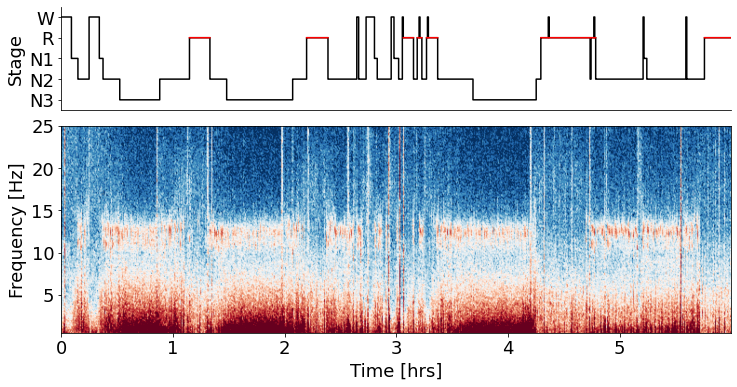

In [5]:
# We use data[0, :] to select only the first channel, which in this case is Cz
fig = yasa.plot_spectrogram(data[0, :], sf, hypno)

The top panel shows the full-night hypnogram, and the bottom panel show the time-frequency representation of the full-night recording, with warmer colors indicating greater power in the frequency range defined on the left y-axis. Notice how we can definitely see some spindles-related activity around 12-15 Hz during N2 and N3 sleep.

## 2. Apply the sleep spindles detection

To apply the multi-channel detection, we use the [yasa.spindles_detect](https://raphaelvallat.com/yasa/build/html/generated/yasa.spindles_detect.html) function. We also pass the hypnogram to restrain the detection to specific sleep stages, which are defined as integers in the ``include`` argument. Below, we're limiting the detection to NREM sleep, i.e. N1 (=1), N2 (=2) and N3 (=3) sleep.

In [6]:
sp = yasa.spindles_detect(data, sf, ch_names=ch_names, hypno=hypno, include=(1, 2, 3))

# Display the full detection dataframe
sp.summary().round(3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Stage,Channel,IdxChannel
0,522.55,522.78,523.79,1.24,45.569,10.891,2.133,0.470,13.080,16.0,0.184,1,Cz,0
1,585.54,586.09,586.38,0.84,59.683,13.335,2.257,0.476,12.959,10.0,0.647,2,Cz,0
2,598.08,598.62,599.52,1.44,79.824,16.180,2.376,0.423,12.895,19.0,0.372,2,Cz,0
3,604.37,604.73,605.09,0.72,60.745,12.820,2.220,0.355,12.646,9.0,0.493,2,Cz,0
4,607.53,607.98,608.05,0.52,50.211,13.847,2.358,0.258,13.450,6.0,0.849,2,Cz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661,20498.20,20498.74,20499.22,1.02,83.898,19.548,2.610,0.516,12.320,12.0,0.524,2,Pz,2
1662,20512.68,20512.95,20513.34,0.66,55.172,12.328,2.305,0.367,13.182,8.0,0.403,2,Pz,2
1663,20524.99,20525.30,20525.60,0.61,66.410,17.256,2.623,0.304,12.763,7.0,0.500,2,Pz,2
1664,20542.93,20543.36,20544.61,1.68,78.707,14.402,2.108,0.285,12.479,20.0,0.254,2,Pz,2


Using the [summary](https://raphaelvallat.com/yasa/build/html/generated/yasa.SpindlesResults.html#yasa.SpindlesResults.summary) method, we can easily get the spindles parameters, averaged across channel and sleep stage. The ``Density`` column is the number of spindles per minutes of each stage. For example, in the first row (Stage = 1, Channel = Cz), a density of 2.0 means that there are 2 spindles per minutes of N1 sleep detected on Cz.

In [7]:
sp.summary(grp_chan=True, grp_stage=True, aggfunc='mean')

Count   Density  Duration  Amplitude        RMS  AbsPower  \
Stage Channel                                                              
1     Cz          22  2.000000  1.076818  76.171830  16.811762  2.442113   
      Fz          17  1.545455  0.954706  78.981920  17.369136  2.497082   
      Pz          24  2.181818  1.052917  69.408419  15.242759  2.350930   
2     Cz         533  3.352201  1.031313  80.188075  17.554238  2.456319   
      Fz         432  2.716981  0.967384  71.540363  15.722079  2.350895   
      Pz         569  3.578616  1.036151  72.033388  15.639326  2.344378   
3     Cz          30  0.329670  0.802000  80.747501  18.992868  2.558522   
      Fz          19  0.208791  0.747895  71.938445  17.395077  2.472242   
      Pz          20  0.219780  0.724000  73.574532  16.684487  2.405970   

               RelPower  Frequency  Oscillations  Symmetry  
Stage Channel                                               
1     Cz       0.442825  12.721485     13.545455  0.505625  
      Fz       0.383151  12.410013     11.470588  0.550661  
      Pz       0.430474  12.840830     13.083333  0.464885  
2     Cz       0.409467  12.630792     12.757974  0.520106  
      Fz       0.388938  12.469967     11.805556  0.511310  
      Pz       0.398597  12.628121     12.797891  0.511045  
3     Cz       0.328556  12.493367      9.700000  0.541472  
      Fz       0.319464  12.359265      9.000000  0.506348  
      Pz       0.317432  12.597020      9.000000  0.555019

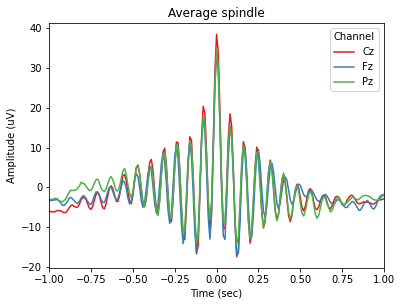

In [8]:
# Plot an average template per channel
sp.plot_average(ci=None, palette="Set1");

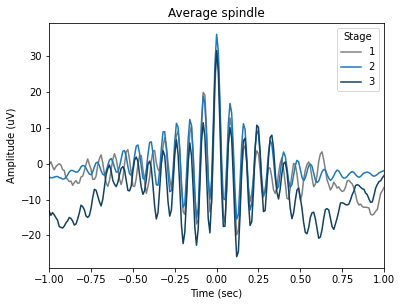

In [9]:
# Plot an average template per stage, using a custom color palette
sp.plot_average(hue="Stage", ci=None, palette=['tab:grey', 'tab:blue', '#114061']);

**Detection on N2 and N3 sleep only (exclude N1)**

In [10]:
sp = yasa.spindles_detect(data, sf, ch_names=ch_names, hypno=hypno, include=(2, 3))

# Now we're only grouping (= stratifying) by stage but not by channel
# We're also using the median instead of the mean to calculate the average spindles features
sp.summary(grp_chan=False, grp_stage=True, aggfunc='median').round(3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


,Count,Density,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Stage,,,,,,,,,,
2,1532,9.635,0.94,71.717,15.664,2.375,0.380,12.549,12.0,0.518
3,69,0.758,0.68,71.868,17.740,2.495,0.314,12.396,8.0,0.500


**Detection on the whole recording**

If we finally decide to apply the detection on the full recording, i.e. not limiting the detection to any sleep stages, we can simply remove the ``hypno=hypno`` argument.

In [11]:
sp = yasa.spindles_detect(data, sf, ch_names=ch_names)

# Here we can only average across channels since sleep stage are unknown.
sp.summary(grp_chan=True).round(3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


,Count,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Channel,,,,,,,,,
Cz,670,1.041,78.698,17.166,2.428,0.404,12.656,12.857,0.519
Fz,551,0.986,70.968,15.504,2.329,0.382,12.484,12.018,0.517
Pz,696,1.036,70.985,15.399,2.327,0.396,12.664,12.812,0.513


In [13]:
!pip install ipympl 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 510 kB 4.1 MB/s 
     |████████████████████████████████| 11.2 MB 52.9 MB/s 
     |████████████████████████████████| 959 kB 65.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [14]:
# Visual inspection of the detected spindles
%matplotlib widget
# sp.plot_detection();